# Q2 (In Python)

In [1]:
### library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from scipy.stats import norm, multivariate_normal, invgamma, poisson
from numpy.linalg import inv, det, cholesky # linalg.pinv: Compute the (Moore-Penrose) pseudo-inverse of a matrix
from numpy import matmul

from patsy import dmatrix  # For bspline `bs'

warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams['figure.facecolor'] = 'white'
np.set_printoptions(suppress=True)

# Q2.  
Consider a nonparametric regression model  
$$ \begin{aligned} y_i = sin^3(2 \pi x_i^3) + \epsilon_i, \quad \epsilon_i \sim \text{N}(0, 0.1^2), \quad i = 1, \dots, n.\end{aligned}$$  
Let $x_i = (2i - 1)/1000, i = 1, \dots, n$ with $n = 500$.

## (a)
We approximate the target function using the cubic spline with L interior uniform knots such that there are $H = L + 4$ basis terms. Fro $H=15$, generate design matries using the truncated power basis, polynomial radial basis, and B-sline basis (`bs` function with and intercept). Using software, verify that the column spaces of the three design matrices are identical.

In [53]:
#################################################################
## Generate X and y
#################################################################
def generate_simulated_data(n, sigma2):
    X = np.array([(2 * i - 1)/1000 for i in range(1, n+1)])
    mu_y = (np.sin(2 * np.pi * (X**3)))**3
    y = np.random.normal(mu_y, np.sqrt(sigma2))

    return X, y

def true_function(x):
    return (np.sin(2 * np.pi * (x**3)))**3

#################################################################
## Generate uniform knots
#################################################################
def generate_unif_knots(X, L):
    knots = np.linspace(0, 1, L+2)[1:L+1]
    
    return knots

#################################################################
## Basis function 1
# 1. Truncated power basis
# 2. Polynomial radial basis
# 3. B-Spline basis
#################################################################
def truncated_power_basis(x, k, knot):
    """ Truncated power basis for univariate x with one knot """
    return max(0, x - knot)**k

def polynomial_radial_basis(x, k, knot):
    """ Polynomial radial basis for univariate x with one knot """
    return np.abs(x - knot)**k

def evalutation(x, k, knots, function):
    """ Array of basis funtion evaluated in univarate x"""
    L = len(knots)    
    basis = np.zeros(L + k + 1)

    # Start with the terms associated with the knots
    basis[:L] = np.array([function(x, k, knots[i]) for i in range(L)])

    # Append polynomial terms
    for i in range(k+1):
        basis[L+i] = x**i

    return basis

def bspline_basis(X, k, knots):
    """ Projection matrix using B-spline basis with X """
    bspline_proj = dmatrix("bs(X, knots=knots, degree=k, include_intercept=True) - 1",
                            {"X": X, "knots": knots, "k": k})
    return np.asarray(bspline_proj)

#################################################################
## Fit the model
# Generate projection matrix
# Prediction
#################################################################
from numpy.linalg import pinv  
def Generate_proj_matrix(matrix):
    return (matrix @ inv(matrix.T @ matrix)) @ matrix.T

def pred(y, design_matrix):
    pred = design_matrix @ ((pinv(design_matrix.T @ design_matrix) @ design_matrix.T) @ y)
    return pred

### Generate simulated data, X and y

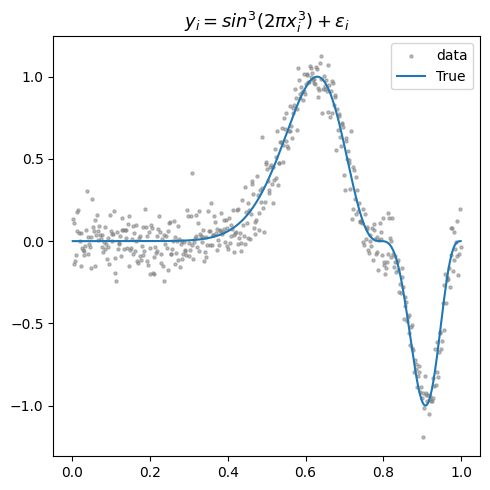

In [54]:
n = 500; sigma2 = 0.1**2
X, y = generate_simulated_data(n, sigma2)

plt.figure(figsize=(5, 5))
plt.scatter(X, y, label='data', s=5, alpha=0.5, color='gray')
plt.plot(X, true_function(X), label='True')

plt.legend()
plt.title(f'$y_i = sin^3(2 \\pi x_i^3) + \\epsilon_i$', fontsize=13)
plt.tight_layout()
plt.savefig('Q2_b.png', dpi=125)
plt.show()

### Generate interior uniform knots  


In [5]:
# Basic information
k = 3   # degree, cubic spline, order K+1 
H = 15  # number of basis
L = H - (k + 1)  # num of interior knots (11)

# Generate uniform knots
knots = generate_unif_knots(X, L)
knots

array([0.08333333, 0.16666667, 0.25      , 0.33333333, 0.41666667,
       0.5       , 0.58333333, 0.66666667, 0.75      , 0.83333333,
       0.91666667])

### Design matrix

In [6]:
# 1. Using truncated power basis
W_truncated = np.zeros((n, H))
for i in range(n):
    W_truncated[i] = evalutation(X[i], k, knots, truncated_power_basis)

# 2. Using polynomial radial basis
W_polynomial = np.zeros((n, H))
for i in range(n):
    W_polynomial[i] = evalutation(X[i], k, knots, polynomial_radial_basis)

# 3. Using B-spline basis
W_bspline = bspline_basis(X, k, knots)

#### Do they span same column spaces?

In [7]:
proj_matrix_truncated = Generate_proj_matrix(W_truncated)
proj_matrix_polynomial = Generate_proj_matrix(W_polynomial)
proj_matrix_bspline = Generate_proj_matrix(W_bspline)

# Check whether the projection matrices are the same in rounding 4 digits.
print(f'Are truncated projection matrix and polynomial projected matrix same?')
print(np.allclose(proj_matrix_truncated, proj_matrix_polynomial, rtol=0.01))
print(f'Are truncated projection matrix and bspline projected matrix same?')
print(np.allclose(proj_matrix_truncated, proj_matrix_bspline, rtol=0.01))

Are truncated projection matrix and polynomial projected matrix same?
True
Are truncated projection matrix and bspline projected matrix same?
True


### Linear regression fit

In [8]:
pred_truncated = pred(y, W_truncated)
pred_polynomial = pred(y, W_polynomial)
pred_bspline = pred(y, W_bspline)

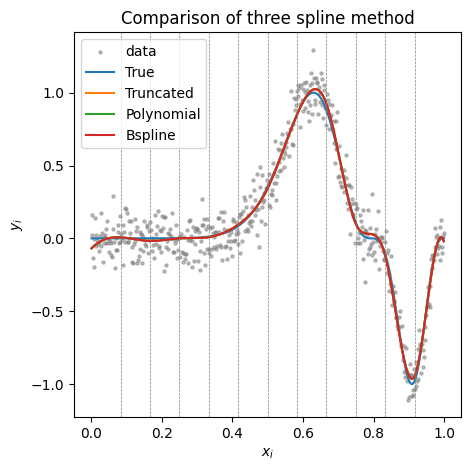

In [52]:
plt.figure(figsize=(5, 5))

plt.scatter(X, y, label='data', s=5, alpha=0.5, color='gray')
plt.plot(X, true_function(X), label='True')
plt.plot(X, pred_truncated, label='Truncated')
plt.plot(X, pred_polynomial, label='Polynomial')
plt.plot(X, pred_bspline, label='Bspline')
[plt.axvline(knot, linestyle='dashed', linewidth=0.5, color='gray') for knot in knots[:-1]]
plt.axvline(knots[-1], linestyle='dashed', linewidth=0.5, color='gray')

plt.xlabel(f'$x_i$')
plt.ylabel(f'$y_i$')
plt.title(f'Comparison of three spline method')
plt.legend()
plt.savefig('Q2_b_1.png', dpi=125)
plt.tight_layout
plt.show()

## (b)
Rather than fixing H, we now explore a model-averaged estimate of the target function. Using the above model and $x_i$ with n=500, generate $y_i$, $i = 1, \dots, n$. With the design matrix generated by the B-spline, put the g-prior on the coefficients $\beta_H$ with $g=n$, the Jeffreys prior on $\sigma^2$, and a Poisson prior Pois(1) on L. For $x_0 = j/1000, j=1, \dots, 999$, obtain the model average pointwise posteriors for $\mu_0$. Draw the posterior mean and the 95% credible interval for every $x_0$, which portrays the posterior mean curve and the 95% credible band on [0, 1]

### likelihood
$p(y | \beta_H, \sigma^2, H) \sim N_H \left(W_H \beta_H, \sigma^2 I_n \right)$


### Prior
1. $p(\sigma^2) \propto (\sigma^2)^{-1}$ 
2. $p(H) = p(L) \sim Pois(1)$
3. $\beta_H | \sigma^2, H \sim N_H \left(0, g\sigma^2 (W_H^T W_H)^{-1} \right)$ (g-prior)

### Posterior
1. $p(\beta_H | \sigma^2, H, y) \sim N_H \left(\frac{g}{1+g}(W_H^{T}W_H)^{-1}W_H^{T}y, \frac{g\sigma^2}{1+g}(W_H^T W_H)^{-1} \right)$  
2. $p(\sigma^2 | H, y) \sim Inv-Gamma\left( \frac{n+1}{2}, \frac{1}{2}y^T (I_n - \frac{g}{g+1} W_H(W_h^T W_H)^{-1}W_H^T)y \right)$
3. $p(H | y) \propto p(H) \{\frac{1}{2}y^T (I_n - \frac{g}{g+1} W_H(W_h^T W_H)^{-1}W_H^T)y \}^{-\frac{n+1}{2}}$

#### Step 1) Calculate normalize marginal posterior $p(H|y)$
 - To obtain exact marginal posterior probability of H, let's assume that H can have a maximum value of 30. Then the unnormalized posterior can be calculated of all cases of H, and the normalizing constant can be computed to obtain the normalized posterior of H.

In [10]:
def unnormalized_posterior_H(X, L):
    ## Define Design matrix W_H for model H with interior knots L
    k = 3
    W = bspline_basis(X, k, generate_unif_knots(X, L))
    n, H = W.shape
    g = n  # for g-prior
    
    # log prior
    log_prior = poisson.logpmf(L, mu=1)
    # log marginal likelihood
    epsilon = 1e-4
    factor1 = (W @ inv(W.T @ W)) @ W.T
    log_marginal_likelihood = (- (n + 1) / 2) * \
        np.log(((y.T @ (np.identity(n) - (g / (g + 1)) * factor1)) @ y) / 2)
    
    # unnormalized posterior
    posterior = np.exp(log_prior + log_marginal_likelihood)
    return posterior

def posterior_H(X, max_L):
    constant = 0
    unnormalized = np.zeros(max_L)
    for l in range(max_L):
        unnormalized[l] = unnormalized_posterior_H(X, l+1)
        constant += unnormalized[l]
    
    # Normalize posterior with constant
    posterior_H = unnormalized / constant

    return posterior_H

In [11]:
max_L = 30
posterior_H = posterior_H(X, max_L)
posterior_H

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.09947506, 0.89921775, 0.00115973, 0.00008728, 0.00000481,
       0.00000155, 0.00002809, 0.00002439, 0.00000111, 0.00000022,
       0.00000001, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

#### Step 2. Pointwise posterior of $\mu^{(t)}(x_0)$
- Draw $H^{(t)}$ from $p(H|y)$
- Draw $\sigma^2$ from $p(\sigma^2 | H, y)$ given $H^{(t)}$
- Draw $\beta^{(t)}_1, \dots \beta^{(t)}_{H^{(t)}}$ from $p(\beta | \sigma^2, H, y)$ given $H^{(t)}, \sigma^2$

In [12]:
def sampling(X, posterior_H):
    """ For one iteration """

    # 1. Sampling H from p(H|y)
    max_L = len(posterior_H) 
    L_sample = np.random.choice(np.arange(1, max_L + 1), p=posterior_H)

    # 2. Generate design matrix for H
    k = 3
    W = bspline_basis(X, k, generate_unif_knots(X, L_sample))
    n, H = W.shape
    g = n  # for g-prior

    # 3. Sampling sigma^2 from p(sigma^2 | H, y)
    alpha = (n + 1) / 2
    factor1 = (W @ inv(W.T @ W)) @ W.T
    beta = ((y.T @ (np.identity(n) - (g / (g + 1)) * factor1)) @ y) / 2
    sigma2_sample = invgamma.rvs(a=alpha, scale=beta, size=1)

    # 4. Sampling beta_H from p(beta_H | sigma^2, H, y)
    mean = (inv(W.T @ W) @ W.T) @ y * (g / (1 + g))
    A = cholesky(inv(W.T @ W))
    cov = np.sqrt(g * sigma2_sample / (1 + g)) * A
    beta_samples = multivariate_normal.rvs(mean, cov)
    beta_samples
    
    return W, L_sample, sigma2_sample, beta_samples

#### Step 3. Model averaging
- The pointwise posterior is averaged over different models (**Bayesian model averaging**)

In [13]:
def model_averaging(X, X_new, n_mcmc):

    k = 3
    averaging_values = np.zeros((len(X_new), n_mcmc))
    for i in range(n_mcmc):
        # 1. sampling H^(t) and beta^t_1, ..., beta^t_H
        W, L, sigma2, betas = sampling(X, posterior_H)

        # 2. Model averaging
        W_new = bspline_basis(X_new, k, generate_unif_knots(X_new, L))
        estimated_X = W_new @ betas

        averaging_values[:, i] = estimated_X
        
        if i % 100 == 0:
            print(i)
        
    # 3. posterior mean and 95% credible interval
    posterior_mean = np.mean(averaging_values, axis=1)
    posterior_interval = np.quantile(averaging_values, [0.05, 0.95], axis=1)

    return averaging_values, posterior_mean, posterior_interval

In [14]:
n_mcmc = 1000  # number of mcmc samples
X_new = np.array([j / 1000 for j in range(1, 1000)])  # new X
averaging_values, posterior_mean, posterior_interval = model_averaging(X, X_new, n_mcmc)

0
100
200
300
400
500
600
700
800
900


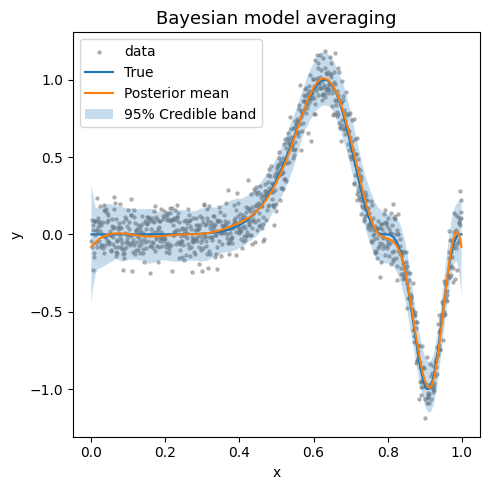

In [51]:
sigma2 = 0.1**2
y_new= np.random.normal((np.sin(2 * np.pi * (X_new**3)))**3, np.sqrt(sigma2))

plt.figure(figsize=(5, 5))
plt.scatter(X_new, y_new, label='data', s=5, alpha=0.5, color='gray')
plt.plot(X_new, true_function(X_new), label='True')
plt.plot(X_new, posterior_mean, label='Posterior mean')
plt.fill_between(X_new, posterior_interval[0], posterior_interval[1], alpha=0.25, label='95% Credible band')
plt.legend()
plt.title(f'Bayesian model averaging', fontsize=13)
plt.ylabel('y')
plt.xlabel('x')
plt.tight_layout()
plt.savefig('Q2_b_2.png', dpi=125)
plt.show()